# |In this notebook we fit a SEIR model with hidden states to the Moscow Covid-19 data

In [190]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm

In [191]:
sns.set()
%matplotlib inline

In [192]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
%autoreload 2

In [194]:
from sir_models.seir_hidden import SEIRHidden, HiddenCurveFitter
from sir_models.utils import stepwise

# Load data

In [195]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

# Model

In [196]:
train_subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-11-30')]

In [197]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [198]:
model = SEIRHidden(verbose=False)
fitter = HiddenCurveFitter()
fitter.fit(model, train_subset)

In [199]:
result = fitter.result
result

In [200]:
train_initial_conditions = fitter.get_initial_conditions(model, train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)

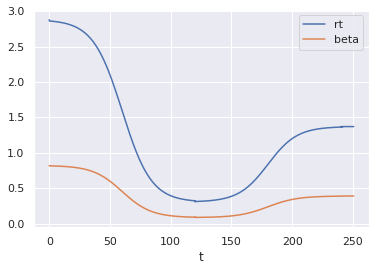

In [201]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

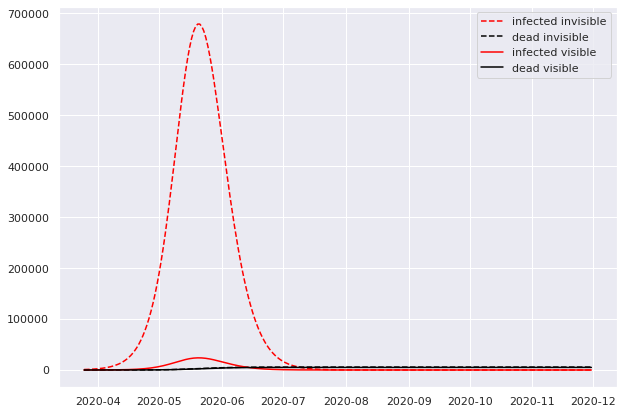

In [202]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected invisible', color='red', linestyle='dashed')
plt.plot(train_subset.date, D, label='dead invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, Iv, label='infected visible', color='red')
plt.plot(train_subset.date, Dv, label='dead visible', color='black')
plt.legend()
plt.show()

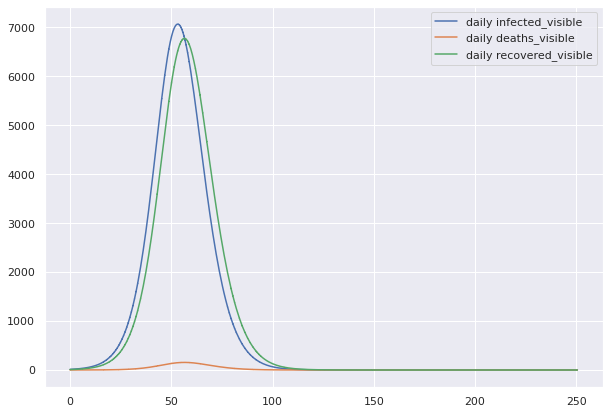

In [203]:
plt.figure(figsize=(10, 7))
plt.plot(history.new_infected_visible, label='daily infected_visible')
plt.plot(history.new_dead_visible, label='daily deaths_visible')
plt.plot(history.new_recovered_visible, label='daily recovered_visible')
plt.legend()
plt.show()

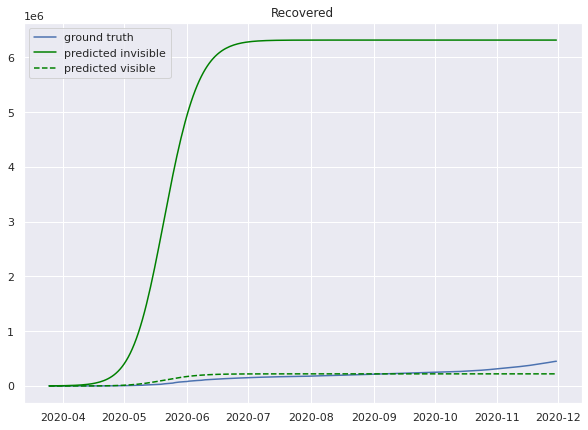

In [204]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted invisible', color='green')
plt.plot(train_subset.date, Rv, label='predicted visible', color='green', linestyle='dashed')
plt.legend()
plt.title('Recovered')
plt.show()

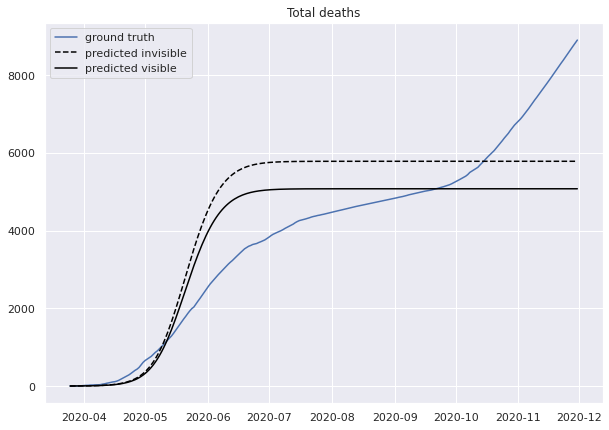

In [205]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

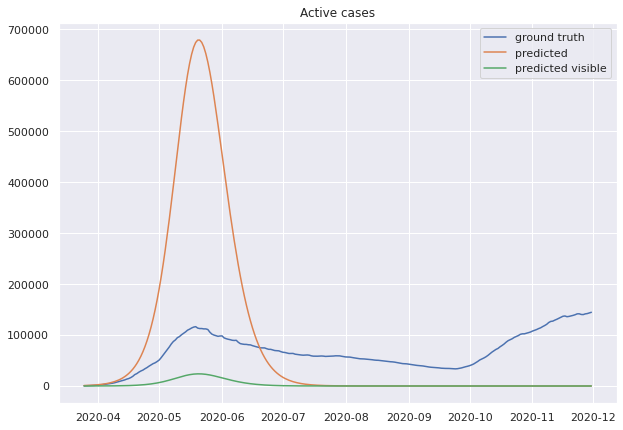

In [206]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.plot(train_subset.date, Iv, label='predicted visible')
plt.legend()
plt.title('Active cases')
plt.show()

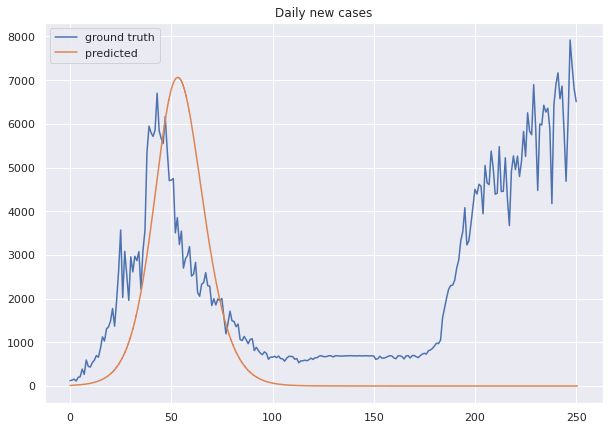

In [207]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_subset)), train_subset['infected_per_day'], label='ground truth')
plt.plot(history.new_infected_visible, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

# Obtain forecast

In [208]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [209]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [212]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [214]:
(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv), history = model.predict(test_t, test_initial_conds)

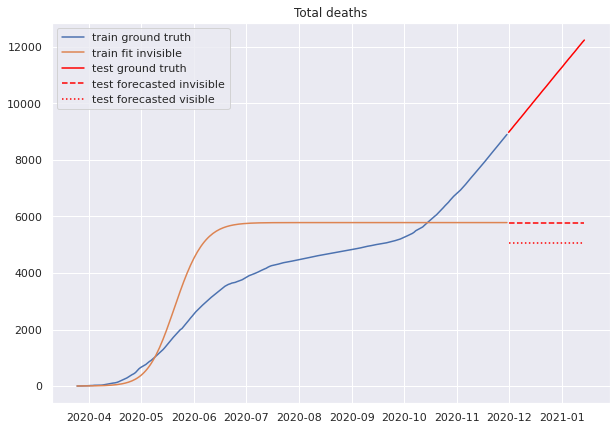

In [219]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

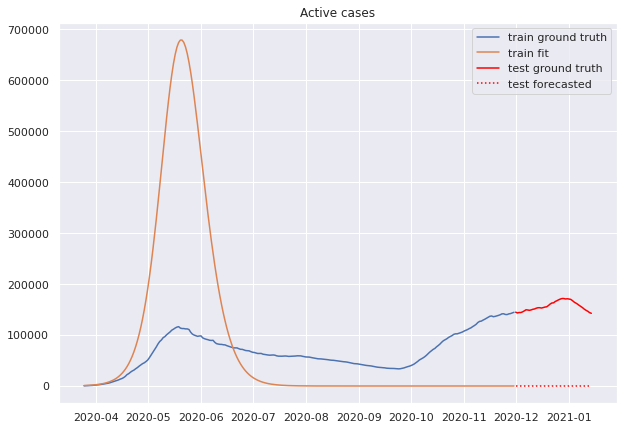

In [220]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Active cases')
plt.show()

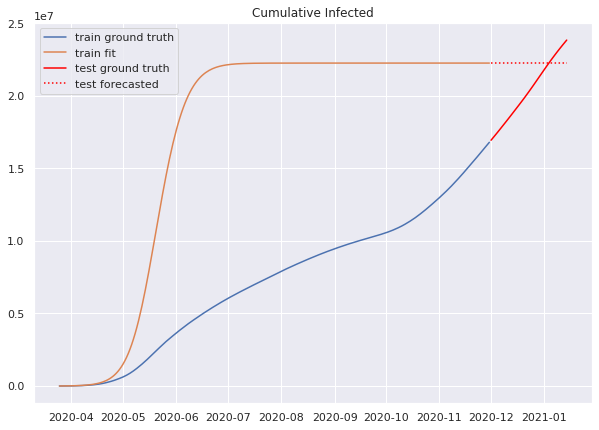

In [221]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected'].sum()+test_subset['infected'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative Infected')
plt.show()

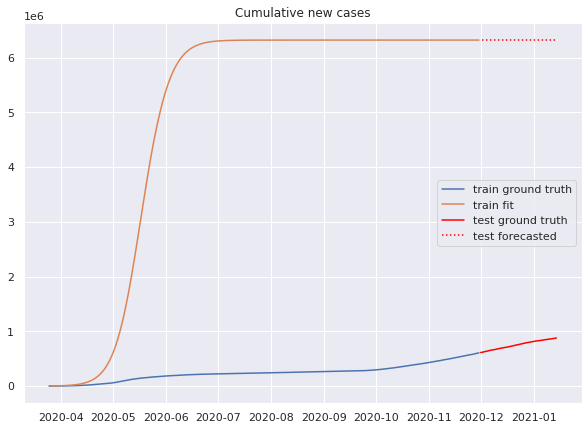

In [222]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected_per_day'].sum()+test_subset['infected_per_day'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date,  (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).sum()+(pd.Series(test_I).diff() + pd.Series(test_R).diff() + pd.Series(test_D).diff()).cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative new cases')
plt.show()

# 1-day ahead evaluate

In [223]:
from sklearn.metrics import mean_absolute_error

In [226]:
n_eval_points = 10
eval_period_start = '2020-05-01'
eval_df = df[df.date >= eval_period_start].iloc[::len(df)//n_eval_points]
pred_dates = []

true_D, true_R = [], []

baseline_pred_D, baseline_pred_R = [], []
model_pred_D, model_pred_R = [], []

for row in tqdm(eval_df.itertuples(), total=len(eval_df)):
    train_df = df.iloc[:row.Index]
    
    pred_dates.append(row.date)
    prev_day = train_df.iloc[-1]
    pred_D = prev_day.total_dead
    pred_R = prev_day.total_recovered
    
    model = SEIRHidden(verbose=False)
    fitter = HiddenCurveFitter()
    fitter.fit(model, train_df)
    
    train_initial_conditions = fitter.get_initial_conditions(model, train_df)
    train_t = np.arange(len(train_df))
    (S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
    
    test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])
    
    (S, E, I, Iv, R, Rv, D, Dv), history = model.predict([train_t[-1], train_t[-1]+1], test_initial_conds)
    
    
    model_pred_D.append(D[-1])
    model_pred_R.append(R[-1])
    baseline_pred_D.append(pred_D)
    baseline_pred_R.append(pred_R)
    true_D.append(row.total_dead)
    true_R.append(row.total_recovered)



In [227]:
baseline_D_mae = mean_absolute_error(true_D, baseline_pred_D)
baseline_R_mae = mean_absolute_error(true_R, baseline_pred_R)

model_D_mae = mean_absolute_error(true_D, model_pred_D)
model_R_mae = mean_absolute_error(true_R, model_pred_R)

print('Baseline D mae', round(baseline_D_mae, 3))
print('Model D mae', round(model_D_mae, 3))

print('Baseline R mae', round(baseline_R_mae, 3))
print('Model R mae', round(model_R_mae, 3))

Baseline D mae 46.222
Model D mae 4913.884
Baseline R mae 2634.556
Model R mae 4063888.329
